<a href="https://colab.research.google.com/github/qwong95/Quantitative-Finance-Final-Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedging, Volatility

In [ ]:
import yfinance as yf
from matplotlib import pyplot as plt
from statsmodels import regression, stats
import statsmodels.api as sm
import scipy.optimize as sco
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.covariance import LedoitWolf
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot


I would like to determine the hedging and volatility of biotech and healthcare stocks starting from the year 2020, as COVID-19 has had a significant impact in these sectors. Some of these stocks followed the market trend of crashing at the height of the pandemic and later surging whereas others followed the opposite direction surged almost up to 300% but have fallen since. I would like to know if investing in a basket consisting of these stocks would be ideal and if hedging would help. This is based on Matthew's last course notes.

In [ ]:
Basket = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP','MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV']
stock_data = yf.download(Basket, start="2020-01-01")

[*********************100%%**********************]  20 of 20 completed


In [ ]:
prices_yf_adj_close = stock_data['Close']
prices_yf_adj_close = prices_yf_adj_close.dropna()

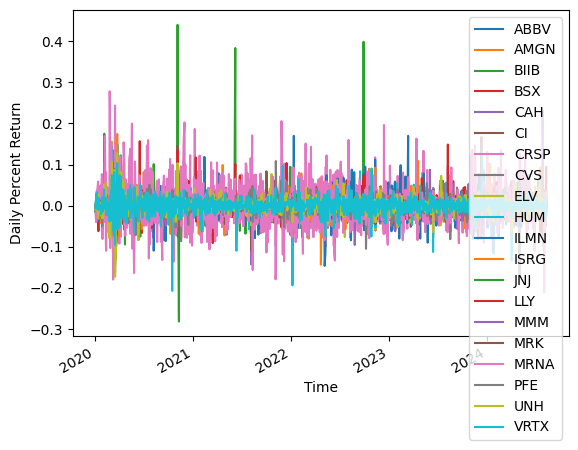

In [ ]:
# stock returns on all Data set
Rets = prices_yf_adj_close.pct_change()[1:]

Rets.plot()
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend();

# Residuals

We define a bet as the forecast of the residual of a security return. This forecast can be implicit -- i.e., we buy a stock and thus implicity we forecast that the stock will go up. This is simply the return less a hedge. We use the Ledoit-Wolf covariance estimator to assess our covariance in all cases. For more information on why we use Ledoit-Wolf instead of typical sample covariance, check out Estimating Covariance Matrices.

#  Example 1: No Hedge!
If we go long on a set of securities, but do not hold any short positions, there is no hedge! So the residual is the stock return itself.

$$r_{resid,i} = r_i$$

Let's see what the correlation of our bets are in this case.

In [ ]:
Rets = Rets.fillna(0) # Calculate returns on the 20 stocks
lw_cov = LedoitWolf().fit(Rets).covariance_ # Calculate Ledoit-Wolf estimator

def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

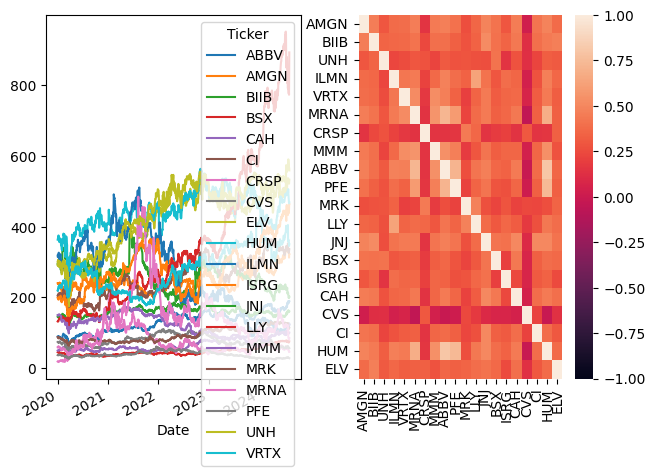

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
# Plot prices
left = prices_yf_adj_close.plot(ax=ax1)
# Plot covariance as a heat map
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=Basket, yticklabels=Basket)

In [ ]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.3326


[*********************100%%**********************]  20 of 20 completed


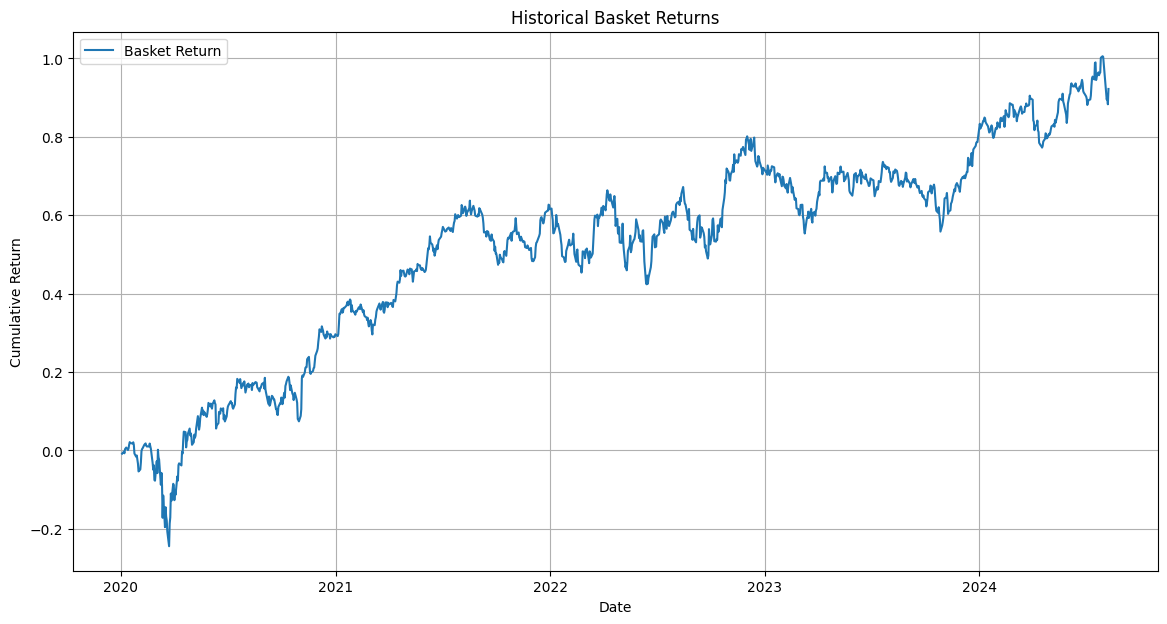

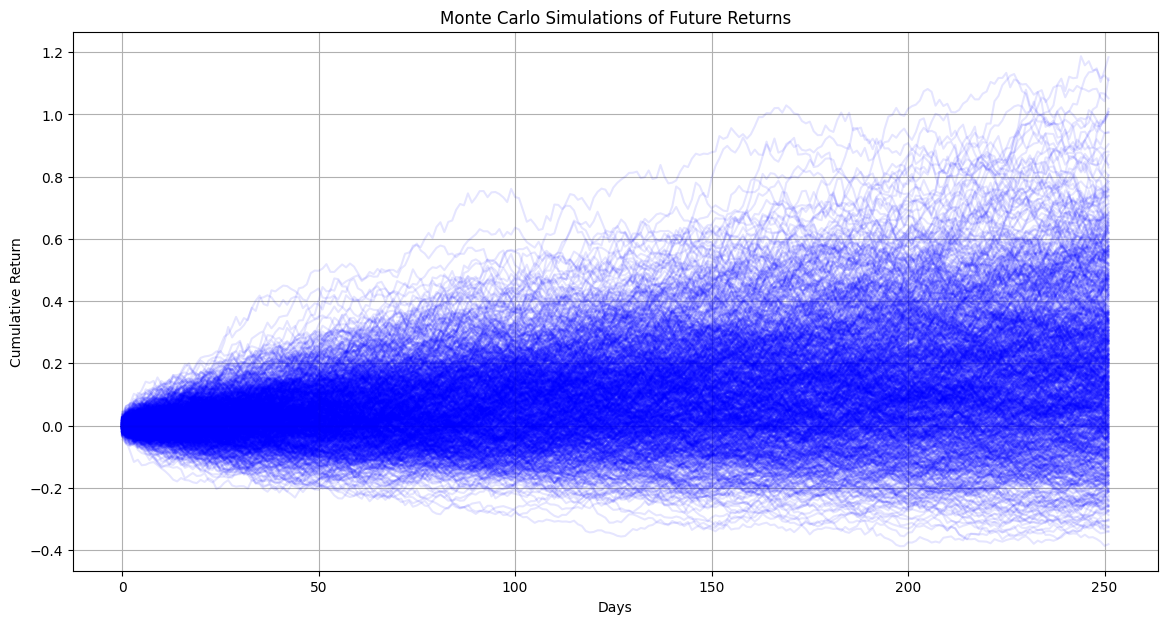

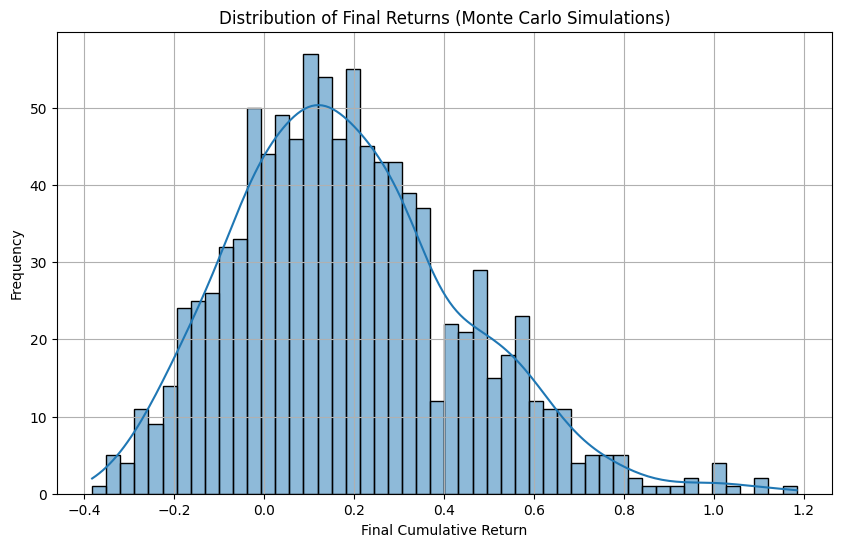

In [ ]:
# Define the stocks and their weights
stocks = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP','MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV']
weights = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]  # Equal weighting

# Download historical data
start_date = '2020-01-01'
end_date = '2024-08-09'
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate weighted returns of the basket
basket_returns = returns.dot(weights)

# Plot historical returns
plt.figure(figsize=(14, 7))
plt.plot(basket_returns.index, (1 + basket_returns).cumprod() - 1, label='Basket Return')
plt.title('Historical Basket Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Monte Carlo Simulation for future returns
num_simulations = 1000
num_days = 252  # Approximate number of trading days in a year

# Compute daily return statistics
mean_return = basket_returns.mean()
std_dev_return = basket_returns.std()

# Simulate future returns
simulated_returns = np.zeros((num_days, num_simulations))
for i in range(num_simulations):
    simulated_returns[:, i] = np.random.normal(mean_return, std_dev_return, num_days)

# Calculate cumulative returns for simulations
cumulative_simulated_returns = (1 + simulated_returns).cumprod(axis=0) - 1

# Plot simulation results
plt.figure(figsize=(14, 7))
plt.plot(cumulative_simulated_returns, color='blue', alpha=0.1)
plt.title('Monte Carlo Simulations of Future Returns')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Plot histogram of final returns
final_returns = cumulative_simulated_returns[-1, :]
plt.figure(figsize=(10, 6))
sns.histplot(final_returns, bins=50, kde=True)
plt.title('Distribution of Final Returns (Monte Carlo Simulations)')
plt.xlabel('Final Cumulative Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Based on the correlation, the basket is sensitive to market change. If the market goes up, then the investor will have an immense return, but if the market goes down, losses will also be great. Overall, however, it appears investing in this will provide a positive return.

# Beta Hedge

In this case, we will assume that each stock position is hedged against the S&P 500. In this case, the residual is calculated as:
$$ r_{resid,i} = r_i - \beta_i r_i $$

where $\beta_i$ is the beta to the market of security $i$ calculated with the [CAPM](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory) and $r_i$ is the return of security $i$.

In [ ]:
# The securities we want to go long on plus the S&P 500
HedgeBasket = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP', '^GSPC', 'MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV']
Tickers = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP','MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV']
prices_HedgeB = yf.download(HedgeBasket, start ='2020-01-01')

rets = prices_HedgeB['Close'].pct_change().fillna(0) # Calculate returns

market = rets['^GSPC']
stock_rets = rets.drop(['^GSPC'], axis=1)

residuals = stock_rets.copy()*0

for stock in stock_rets.columns:
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    residuals[stock] = results.resid

lw_cov2 = LedoitWolf().fit(residuals).covariance_ # Calculate Ledoit-Wolf Estimator

[*********************100%%**********************]  21 of 21 completed


[Text(-3.6805555555555483, 0.5, 'Cumulative Return (%)')]

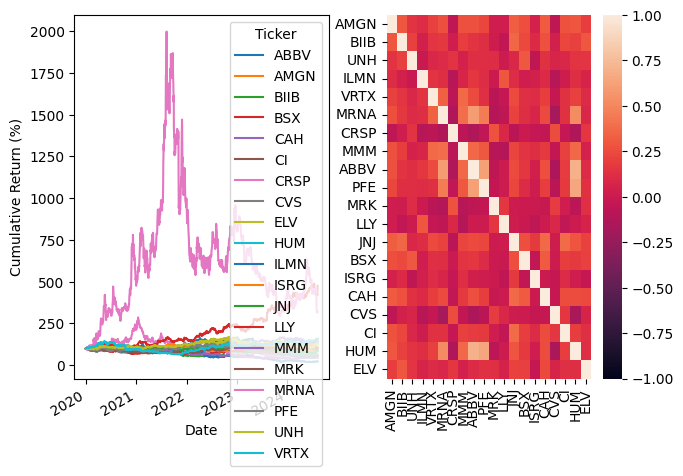

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr2 = extract_corr_from_cov(lw_cov2)
Cumret = 100* (1+residuals).cumprod()
left = Cumret.plot(ax=ax1)
right = sns.heatmap(corr2, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=Tickers, yticklabels=Tickers)
ax1.set( ylabel="Cumulative Return (%)")

In [ ]:
average_corr = np.mean(corr2[np.triu_indices_from(corr2, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.1209


[*********************100%%**********************]  21 of 21 completed


Portfolio Beta: 0.7748997816813733


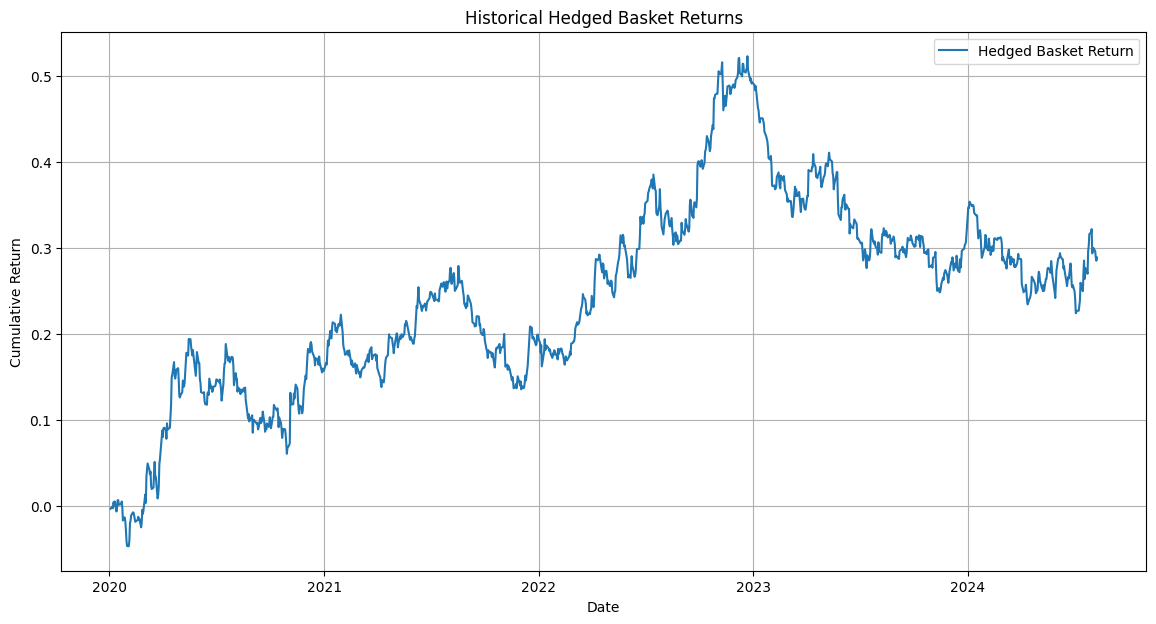

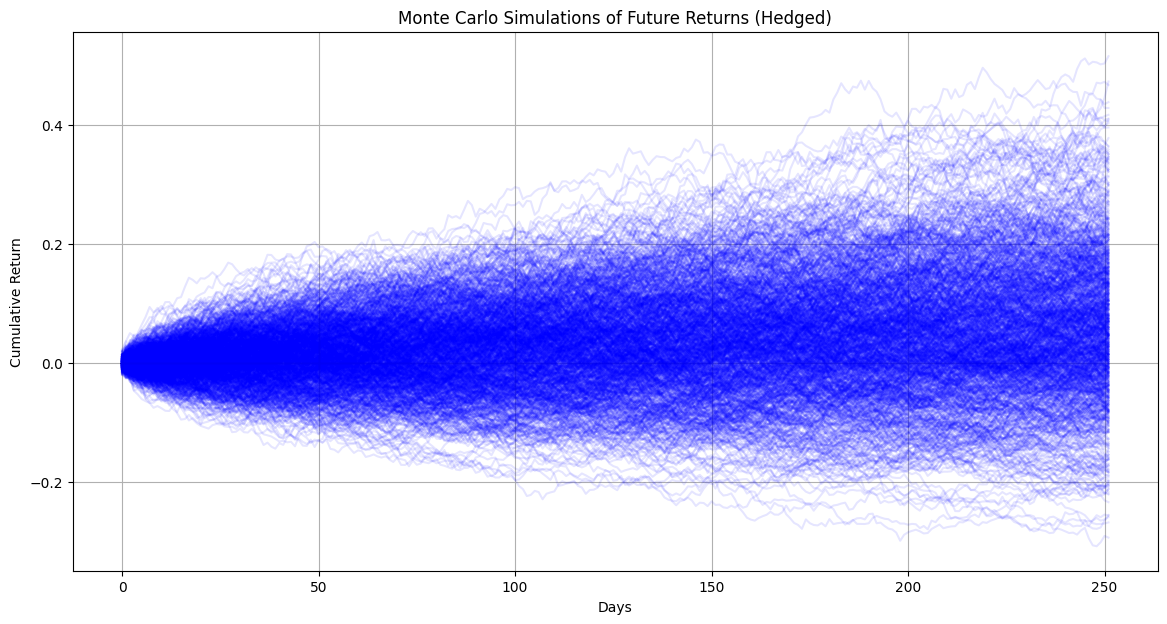

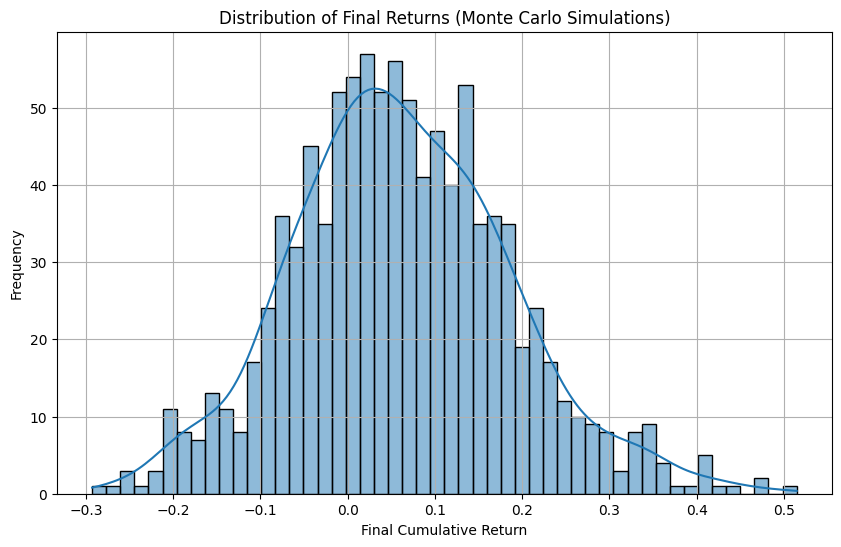

In [ ]:
# Define the stocks and the market index for hedging
stocks = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP','MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV']
weights = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]  # Equal weighting

market_index = '^GSPC'  # S&P 500 Index

# Download historical data
start_date = '2020-01-01'
end_date = '2024-08-09'
data = yf.download(stocks + [market_index], start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()
stock_returns = returns[stocks]
market_returns = returns[market_index]

# Calculate beta for each stock
betas = {}
for stock in stocks:
    model = sm.OLS(stock_returns[stock], sm.add_constant(market_returns)).fit()
    betas[stock] = model.params[market_index]

# Calculate portfolio beta
portfolio_beta = np.dot(list(betas.values()), weights)
print(f'Portfolio Beta: {portfolio_beta}')

# Determine the hedging weight of the market index
hedge_weight = -portfolio_beta

# Adjust portfolio weights
adjusted_weights = weights.copy()
hedged_returns = stock_returns.dot(adjusted_weights) + market_returns * hedge_weight

# Plot historical returns
plt.figure(figsize=(14, 7))
plt.plot((1 + hedged_returns).cumprod() - 1, label='Hedged Basket Return')
plt.title('Historical Hedged Basket Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Monte Carlo Simulation for future returns
num_simulations = 1000
num_days = 252  # Approximate number of trading days in a year

# Compute daily return statistics
mean_return = hedged_returns.mean()
std_dev_return = hedged_returns.std()

# Simulate future returns
simulated_returns = np.zeros((num_days, num_simulations))
for i in range(num_simulations):
    simulated_returns[:, i] = np.random.normal(mean_return, std_dev_return, num_days)

# Calculate cumulative returns for simulations
cumulative_simulated_returns = (1 + simulated_returns).cumprod(axis=0) - 1

# Plot simulation results
plt.figure(figsize=(14, 7))
plt.plot(cumulative_simulated_returns, color='blue', alpha=0.1)
plt.title('Monte Carlo Simulations of Future Returns (Hedged)')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Plot histogram of final returns
final_returns = cumulative_simulated_returns[-1, :]
plt.figure(figsize=(10, 6))
sns.histplot(final_returns, bins=50, kde=True)
plt.title('Distribution of Final Returns (Monte Carlo Simulations)')
plt.xlabel('Final Cumulative Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Although the correlation is still quite high, it is substantially lower than without hedging, which means this strategy allows the investment to be more resistant to market trends. Compared to no hedging, the cumulative return has lower risk but also lower reward. Overall, the return is a bit greater due to the lower risk.

# Sector Hedge
The sector return and the market return are themselves highly correlated. As such, one cannot do a multivariate regression due to multicollinearity, a classic violation of regression assumptions. To hedge against both the market and a given security's sector, one first estimate the market beta residuals and then calculate the sector beta on those residuals.

$$
r_{resid,i} = r_i - \beta_i r_i \\
r_{resid_{SECTOR},i}= r_{resid,i} - \beta_{SECTOR,i}r_{resid,i}
$$

Here, $r_{resid, i}$ is the residual between the security return and a market beta hedge and $r_{resid_{SECTOR}, i}$ is the residual between *that* residual and a hedge of that residual against the relevant sector.

I will hedge my basket against the biotech and healthcare sectors.

In [ ]:
SectorHedgeBasket = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP', '^GSPC', 'MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV', 'XBI', 'XLV']
sectors = ['XBI', 'XLV']

prices_SHedgeB = yf.download(SectorHedgeBasket, start ='2020-01-01', end = '2024-08-09')
sector_data = yf.download(sectors, start='2020-01-01', end='2024-08-09')

rets = prices_SHedgeB['Close'].pct_change().fillna(0) # Calculate returns

# Get market hedge ticker
mkt = ['^GSPC']
# Get sector hedge tickers
# XBI is biotech, XLV is healthcare
sector_1_hedge = ['XBI']
sector_2_hedge = ['XLV']

# Identify securities for each sector
sector_1_stocks = ['AMGN','BIIB','ILMN','VRTX','MRNA','CRSP','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG']
sector_2_stocks = ['UNH','MMM', 'CAH','CVS','CI','HUM', 'ELV']

market = rets[mkt]
sector_1_rets = rets[sector_1_hedge]
sector_2_rets = rets[sector_2_hedge]

stock_rets = rets.drop(['^GSPC', 'XBI', 'XLV'], axis=1)
residuals_market = stock_rets.copy()*0
residuals = stock_rets.copy()*0
# Calculate market beta of sector 1 benchmark
model = sm.OLS(sector_1_rets.values, market.values)
results = model.fit()
sector_1_excess = results.resid
# Calculate market beta of sector 2 benchmark
model = sm.OLS(sector_2_rets.values, market.values)
results = model.fit()
sector_2_excess = results.resid

for stock in sector_1_stocks:
    # Calculate market betas for sector 1 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_1_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid

for stock in sector_2_stocks:
    # Calculate market betas for sector 2 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_2_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid

# Get covariance of residuals
lw_cov = LedoitWolf().fit(residuals).covariance_

[*********************100%%**********************]  23 of 23 completed
[*********************100%%**********************]  2 of 2 completed


[Text(-3.6805555555555483, 0.5, 'Cumulative Return (%)')]

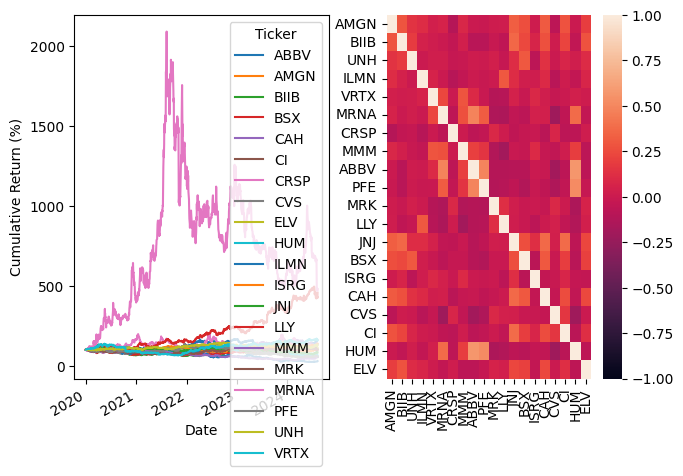

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
Cumret2 = 100* (1+residuals).cumprod()
left = Cumret2.plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=Tickers, yticklabels=Tickers)
ax1.set( ylabel="Cumulative Return (%)")

In [ ]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.0409


The correlation here is much lower than just hedging against the market.

[*********************100%%**********************]  23 of 23 completed
[*********************100%%**********************]  2 of 2 completed


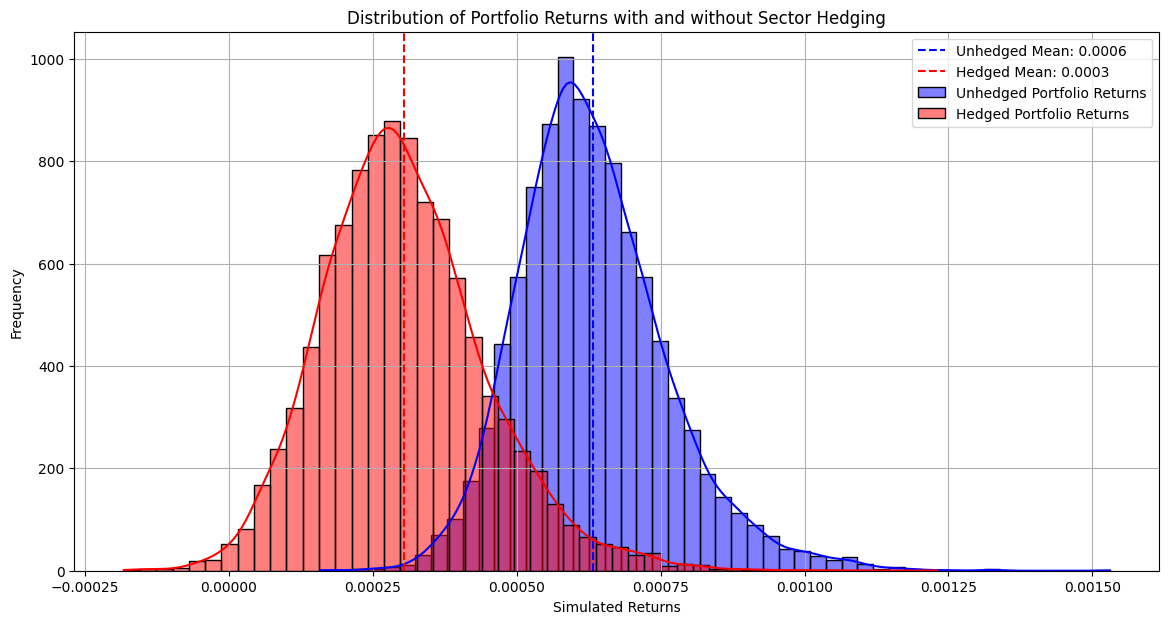

In [ ]:
# Fetch historical data
stocks = ['AMGN','BIIB','UNH','ILMN','VRTX','MRNA','CRSP', '^GSPC', 'MMM','ABBV','PFE','MRK','LLY', 'JNJ', 'BSX', 'ISRG', 'CAH', 'CVS', 'CI', 'HUM', 'ELV', 'XBI', 'XLV']
sectors = ['XBI', 'XLV']

# Download stock and sector data
stock_data = yf.download(stocks, start='2020-01-01', end='2024-01-01')['Adj Close']
sector_data = yf.download(sectors, start='2020-01-01', end='2024-01-01')['Adj Close']

# Calculate daily returns
stock_returns = stock_data.pct_change().dropna()
sector_returns = sector_data.pct_change().dropna()

# Monte Carlo simulation
num_simulations = 10000
num_days = len(stock_returns)

portfolio_simulations = np.zeros(num_simulations)
hedged_simulations = np.zeros(num_simulations)

for i in range(num_simulations):
    # Generate random weights for stocks and sectors
    stock_weights = np.random.dirichlet(np.ones(len(stocks)))
    sector_weights = np.random.dirichlet(np.ones(len(sectors)))

    # Calculate portfolio returns
    portfolio_returns = (stock_returns * stock_weights).sum(axis=1)
    hedged_returns = portfolio_returns - (sector_returns * sector_weights).sum(axis=1)

    # Store simulated results
    portfolio_simulations[i] = portfolio_returns.mean()
    hedged_simulations[i] = hedged_returns.mean()

# Compute statistics
portfolio_mean = portfolio_simulations.mean()
portfolio_std = portfolio_simulations.std()

hedged_mean = hedged_simulations.mean()
hedged_std = hedged_simulations.std()

# Plot results
plt.figure(figsize=(14, 7))

# Plot histogram of simulated returns for the portfolio
sns.histplot(portfolio_simulations, kde=True, color='blue', bins=50, label='Unhedged Portfolio Returns')
plt.axvline(portfolio_mean, color='blue', linestyle='--', label=f'Unhedged Mean: {portfolio_mean:.4f}')

# Plot histogram of simulated returns for the hedged portfolio
sns.histplot(hedged_simulations, kde=True, color='red', bins=50, label='Hedged Portfolio Returns')
plt.axvline(hedged_mean, color='red', linestyle='--', label=f'Hedged Mean: {hedged_mean:.4f}')

plt.title('Distribution of Portfolio Returns with and without Sector Hedging')
plt.xlabel('Simulated Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()




Based on the simulation, investing unhedged would provide a greater return than sector hedging.

## ARIMA For the VIX

We will use ARIMA to predict the volatility in the future based on historical data.

In [ ]:
vix = yf.download('^VIX', start="2020-01-01")

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

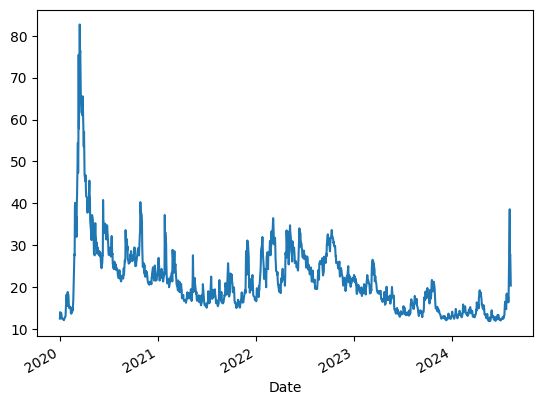

In [ ]:
vix['Close'].plot()

At the height of the pandemic, the market as a whole was extremely volatile and has stabilized a bit since.

In [ ]:
vix_close = vix['Close']

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

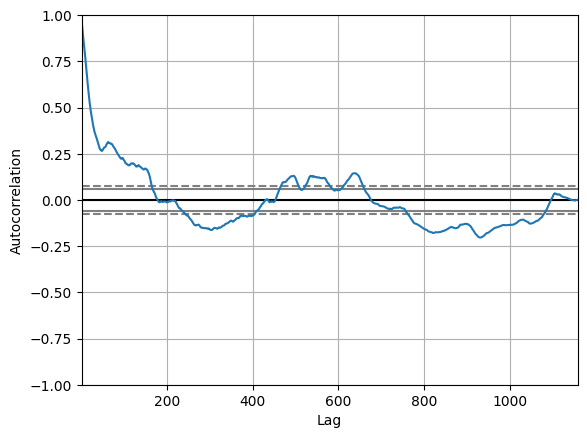

In [ ]:
autocorrelation_plot(vix_close)

Test RMSE: 2.044


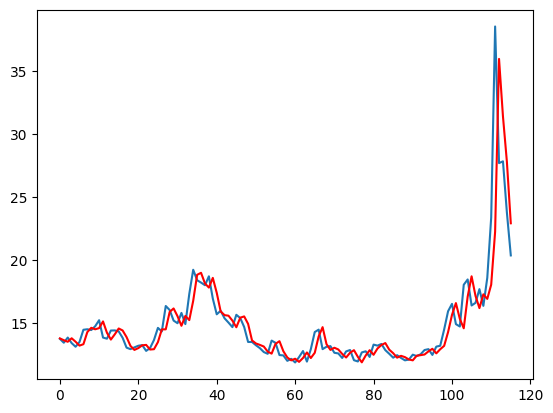

In [ ]:
series = vix_close
# fit model

# split into train and test sets
X = series.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Conclusion

Given the basket of healthcare and biotech stocks, it is surprising that sector hedging would give a smaller return than without hedging. However, beta hedging would give out a larger return. It is not surprising that ultimately,